Import stuff I need

In [1]:
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


Upload into memory the data files. They are in parquet format.

In [2]:
table_sales = pq.read_table('../data/raw/modeldata.parquet')

table_sales includes data for homes in Cook County that have been sold in the past seven years. table includes data for all homes regardless of a sale. 

Convert to pandas dataframes.

In [3]:
df_sales = table_sales.to_pandas()

examine columns

In [4]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346293 entries, 0 to 346292
Data columns (total 98 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   meta_pin                      346293 non-null  object  
 1   meta_year                     346293 non-null  float64 
 2   meta_class                    346293 non-null  object  
 3   meta_town_code                346293 non-null  object  
 4   meta_nbhd                     346293 non-null  object  
 5   meta_2yr_pri_board_est_bldg   345640 non-null  float64 
 6   meta_2yr_pri_board_est_land   345640 non-null  float64 
 7   meta_1yr_pri_board_est_bldg   346293 non-null  float64 
 8   meta_1yr_pri_board_est_land   346293 non-null  float64 
 9   meta_mailed_est_bldg          346293 non-null  float64 
 10  meta_mailed_est_land          346293 non-null  float64 
 11  meta_certified_est_bldg       346293 non-null  float64 
 12  meta_certified_est_land       

On-line documentation describes some but not all columns. 


df_sales columns should be the same as df except that df_sales also includes sales columns. Let's check.

meta_sales_price is the important column. For my simplified model I'll scrap the others.

Let's focus on homes for the same elementary school in Cook County. Alternatives, use median income as proxy for school ranking. The single district we will focus on is the Bell School district becuase it has a lot of bungaloes and mansions mixed together so it is a district where regression to the mean could be present in the County's model.

In [5]:
df_bell_sales = df_sales[df_sales['geo_school_elem_district']=='BELL']

In [6]:
df_bell_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508 entries, 126575 to 144028
Data columns (total 98 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   meta_pin                      508 non-null    object  
 1   meta_year                     508 non-null    float64 
 2   meta_class                    508 non-null    object  
 3   meta_town_code                508 non-null    object  
 4   meta_nbhd                     508 non-null    object  
 5   meta_2yr_pri_board_est_bldg   508 non-null    float64 
 6   meta_2yr_pri_board_est_land   508 non-null    float64 
 7   meta_1yr_pri_board_est_bldg   508 non-null    float64 
 8   meta_1yr_pri_board_est_land   508 non-null    float64 
 9   meta_mailed_est_bldg          508 non-null    float64 
 10  meta_mailed_est_land          508 non-null    float64 
 11  meta_certified_est_bldg       508 non-null    float64 
 12  meta_certified_est_land       508 non-null

The features I keep, in additon to the unque pin identifier for each property, as well as year and class of the property are the numeric ones rather than categories: land square footage, age, # rooms, #  bedrooms, # fireplaces, # full bathrooms, # half bathrooms, "ot_impr", "building square footage, logitude, and latitude. All of these are self explanatory except "ot_impr" which I might drop if I can't figure out from the documentation what it means. All of these features relate to the property except for the logitude and latitude, which relate to location. Prof Nick Tideman, an economics professor at Virgina Tech, whose research is on land values tells me that the proper way to model this system is to model land values seperately from building values and then add them together. To do this I would have to seperatly identify those properties that are flipped, and assume they are sold at their land value alone. But for my first attempt at this, I will model the land plus property as a single price which is what Cook County does. 

In [7]:
df_bell_sales.meta_class.value_counts()

211    207
278    120
206     68
203     39
205     38
204     10
212      8
202      7
208      7
295      4
Name: meta_class, dtype: int64

class 211 and 212 are condos. Lets' remopve those

In [8]:
df_bell_sales = df_bell_sales[(df_bell_sales.meta_class != '211')&(df_bell_sales.meta_class !='212')]

In [9]:
df_bell_sales.meta_class.value_counts()

278    120
206     68
203     39
205     38
204     10
202      7
208      7
295      4
Name: meta_class, dtype: int64

In [10]:
df_bell_sales.meta_modeling_group.value_counts()

SF    293
Name: meta_modeling_group, dtype: int64

In [11]:
df_sales.meta_modeling_group.value_counts()

SF    296509
MF     49784
Name: meta_modeling_group, dtype: int64

In [12]:
df_sales[df_sales.meta_modeling_group == 'MF'].meta_class.value_counts()

211    46750
212     3034
Name: meta_class, dtype: int64

In [13]:
df_bell_sales.meta_sale_date

126575    2017-11-06
126576    2013-10-31
126578    2013-11-18
126579    2014-01-24
126580    2018-03-23
             ...    
144017    2016-10-27
144018    2019-05-17
144019    2013-07-15
144025    2013-05-29
144026    2015-07-22
Name: meta_sale_date, Length: 293, dtype: object

In [14]:
df_bell_sales.char_apts

126575    NaN
126576    NaN
126578    NaN
126579    NaN
126580    NaN
         ... 
144017    NaN
144018    NaN
144019    NaN
144025    NaN
144026    NaN
Name: char_apts, Length: 293, dtype: category
Categories (6, object): ['1', '2', '3', '4', '5', '6']

In [15]:
df_bell_sales.char_ext_wall


126575    1
126576    2
126578    2
126579    1
126580    2
         ..
144017    2
144018    2
144019    2
144025    2
144026    2
Name: char_ext_wall, Length: 293, dtype: category
Categories (4, object): ['1', '2', '3', '4']

In [16]:
df_bell_sales.char_roof_cnst

126575    1
126576    2
126578    1
126579    1
126580    2
         ..
144017    1
144018    1
144019    2
144025    1
144026    1
Name: char_roof_cnst, Length: 293, dtype: category
Categories (6, object): ['1', '2', '3', '4', '5', '6']

In [17]:
df_bell_sales_mf = df_bell_sales.iloc[:,[0,1,2,19,23,24,26,27,28,29,30,31,32,34,35,36,37,38,43,48,89,76,77]]

In [18]:
df_bell_sales_mf.select_dtypes(include='category')

,char_ext_wall,char_roof_cnst,char_bsmt,char_bsmt_fin,char_heat,char_air,char_attic_type,char_gar1_size
126575,1,1,1,3,1,1,3,3
126576,2,2,1,1,1,1,3,3
126578,2,1,1,3,2,1,3,3
126579,1,1,3,1,1,2,1,3
126580,2,2,1,1,1,1,3,3
...,...,...,...,...,...,...,...,...
144017,2,1,1,1,1,1,3,7
144018,2,1,1,1,1,1,3,7
144019,2,2,1,1,1,1,3,3
144025,2,1,1,1,1,1,3,4


In [19]:
df_bell_sales_mf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 126575 to 144026
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   meta_pin               293 non-null    object  
 1   meta_year              293 non-null    float64 
 2   meta_class             293 non-null    object  
 3   meta_sale_price        293 non-null    float64 
 4   char_hd_sf             293 non-null    float64 
 5   char_age               293 non-null    float64 
 6   char_ext_wall          293 non-null    category
 7   char_roof_cnst         293 non-null    category
 8   char_rooms             293 non-null    float64 
 9   char_beds              293 non-null    float64 
 10  char_bsmt              293 non-null    category
 11  char_bsmt_fin          293 non-null    category
 12  char_heat              293 non-null    category
 13  char_air               293 non-null    category
 14  char_frpl              293 non-nul

In [20]:
df_bell_sales_mf.char_ext_wall.value_counts()

2    123
1    121
3     45
4      4
Name: char_ext_wall, dtype: int64

In [21]:
df_bell_sales_mf.char_roof_cnst.value_counts()

1    220
2     58
6     15
3      0
4      0
5      0
Name: char_roof_cnst, dtype: int64

In [22]:
df_bell_sales_mf.char_bsmt.value_counts()

1    271
2     14
3      8
4      0
Name: char_bsmt, dtype: int64

In [23]:
df_bell_sales_mf.char_bsmt_fin.value_counts()

1    183
3    110
2      0
Name: char_bsmt_fin, dtype: int64

In [24]:
df_bell_sales_mf.char_air.value_counts()

1    209
2     84
Name: char_air, dtype: int64

In [25]:
df_bell_sales_mf.char_heat.value_counts()


1    250
2     43
3      0
4      0
Name: char_heat, dtype: int64

In [26]:
df_bell_sales_mf.char_gar1_size.value_counts()


3    184
7     34
4     24
5     24
1     19
2      7
6      1
8      0
Name: char_gar1_size, dtype: int64

All values are non-null expect for 1 entry in # fireplaces. But it is only missing in the sales file. I should be able fill this in from the other file. In fact, the feature values in the sales file should be identical for the same property id's in the main file. Privided the property hasn't flipped. Let check this for 1 pin.

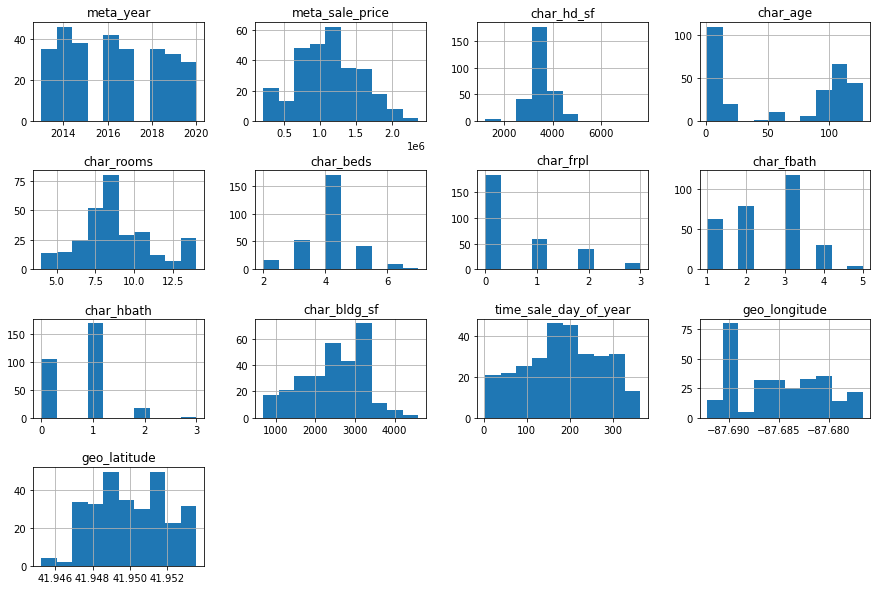

In [27]:
df_bell_sales_mf.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

There appear to be gap years in the sales data. There is only slight evidence for a bimodal sales distribution from slight dip less than 1.5 million. But the age is clearly bimodal. There appear to be outliers in hd_sf, rooms, beds, half baths, and bld_sf, 

In [28]:
df_bell_sales_mf.to_csv('../data/bell_sales_cleaned_mf.csv')

I have saved single family home data in the Bell district. I have retained numerical features plus class.